In [1]:
import sys
sys.path.insert(0, '/home/ldoyle/packages')
import h5py
import numpy as np
from tqdm import tqdm
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import pysindy as ps
from lr_ed import localreg
from datetime import datetime
from scipy.fft import fft, fftfreq,rfft2

import scipy.signal as signal
from obspy.signal import filter as obsfilt
import glob


In [2]:
WEAK = False

x_len = 5000
t_len = 6000

xs = np.arange(x_len)
dt = 1

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]  

if WEAK:
    X, T = np.meshgrid(xs, np.arange(t_len))
    XT = np.asarray([X, T]).T

    pde_lib = ps.WeakPDELibrary(
        library_functions=library_functions,
        function_names=library_function_names,
        derivative_order=4,
        spatiotemporal_grid=XT,
        is_uniform=True,
        K=1000,
    )
else:
    
    pde_lib = ps.PDELibrary(
        library_functions=library_functions,
        function_names=library_function_names,
        derivative_order=4,
        spatial_grid=xs,
        include_bias=True,
        is_uniform=True,
    )
    

## Unfiltered

In [3]:
path = "/data/data2/south-data-ejm/hdd/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/"

init = 11
final= 16

time_subsample = 10
full_dat = np.zeros((5000,(12000//time_subsample)*(final-init)))

k = 0
for i in np.arange(init,final):
    file = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T23"+str(i)+"14Z.h5"
    f = h5py.File(path+file, 'r')
    data = f['Acquisition']['Raw[0]']['RawData'][:, :].astype('int64')
#     timestamp = f['Acquisition']['Raw[0]']['RawDataTime'][:] / 1000000
    f.close()
    
    full_dat[:,k*(12000//time_subsample):(k+1)*(12000//time_subsample)] = data[7500:12500,::time_subsample]
    k+=1
    
working_dat = full_dat/np.std(full_dat)


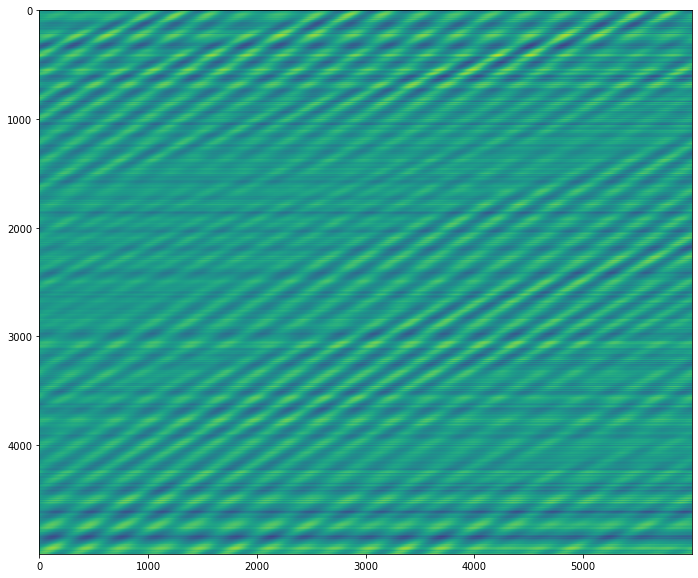

In [4]:
plt.figure(figsize=(12,10))
plt.imshow(full_dat)
plt.show()

In [5]:

working_dat = working_dat.reshape(working_dat.shape[0],working_dat.shape[1],1)


### Dataset 1

In [6]:
thresh = 1e-4
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fba3a1454f0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.0001))

In [7]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.0001
(x0)' = 0.005 x0_1 + 0.003 x0_111


In [8]:
thresh = 1e-6
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fba3a1454f0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=1e-06))

In [9]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 1e-06
(x0)' = 0.005 x0_1 + 0.003 x0_111


In [10]:
thresh = 1e-8
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fba3a1454f0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=1e-08))

In [11]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 1e-08
(x0)' = 0.005 x0_1 + 0.003 x0_111


### Dataset 2

In [12]:
time_subsample = 10
full_dat = np.zeros((5000,6000))

k = 0
for i in np.arange(21,26):
    file = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T23"+str(i)+"14Z.h5"
    f = h5py.File(path+file, 'r')
    data = f['Acquisition']['Raw[0]']['RawData'][:, :].astype('int64')
#     timestamp = f['Acquisition']['Raw[0]']['RawDataTime'][:] / 1000000
    f.close()
    
    full_dat[:,k*(12000//time_subsample):(k+1)*(12000//time_subsample)] = data[7500:12500,::time_subsample]
    k+=1
    


In [13]:
working_dat = full_dat/np.std(full_dat)#*10**6
working_dat = working_dat.reshape(working_dat.shape[0],working_dat.shape[1],1)


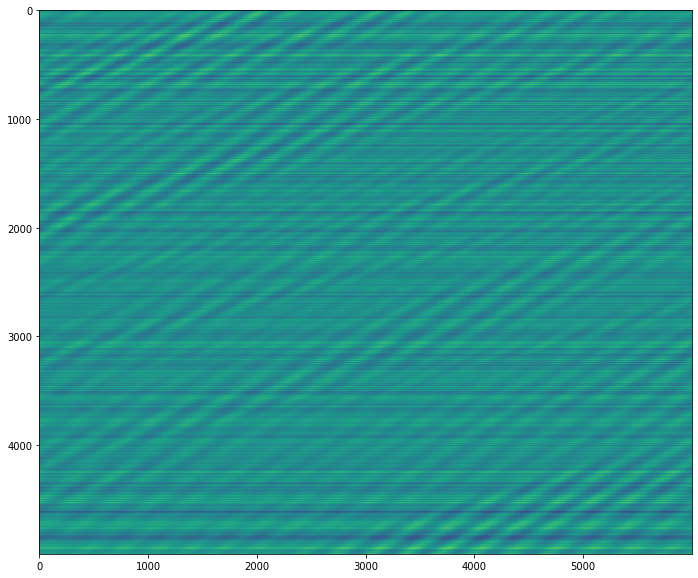

In [14]:
plt.figure(figsize=(12,10))
plt.imshow(working_dat[:,:,0], vmin=-5.,vmax=5.)
plt.show()

In [15]:
thresh = 1e-4
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fba3a1454f0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.0001))

In [16]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.0001
(x0)' = 0.001 x0_1 + 0.001 x0_111


In [17]:
thresh = 1e-6
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fba3a1454f0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=1e-06))

In [18]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 1e-06
(x0)' = 0.001 x0_1 + 0.001 x0_111


In [19]:
thresh = 1e-8
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fba3a1454f0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=1e-08))

In [20]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 1e-08
(x0)' = 0.001 x0_1 + 0.001 x0_111


## Gaussian Filtered



In [21]:
file_list = glob.glob("/home/ldoyle/notebooks/rad_10_smooth_data/*")

In [22]:
# n = 1.4682
# L = 51.04762
working_dat = np.zeros((5000,6000))
b=0
for q in np.arange(5):
#     if b==0:
#         working_dat = np.load(file_list[q])
#         b=1
#     else:
#         working_dat = np.hstack((working_dat, np.load(file_list[q])))
    working_dat[:,q*(1200):(q+1)*1200] = np.load(file_list[q])[:,::10]
        
# working_dat = ((2*np.pi)/2**16)*((1550.12 * 1e-9)/(0.78 * 4 * np.pi * n * L))*working_dat[:,::10]
working_dat = working_dat/(np.std(working_dat))
working_dat = working_dat.reshape(working_dat.shape[0],working_dat.shape[1],1)

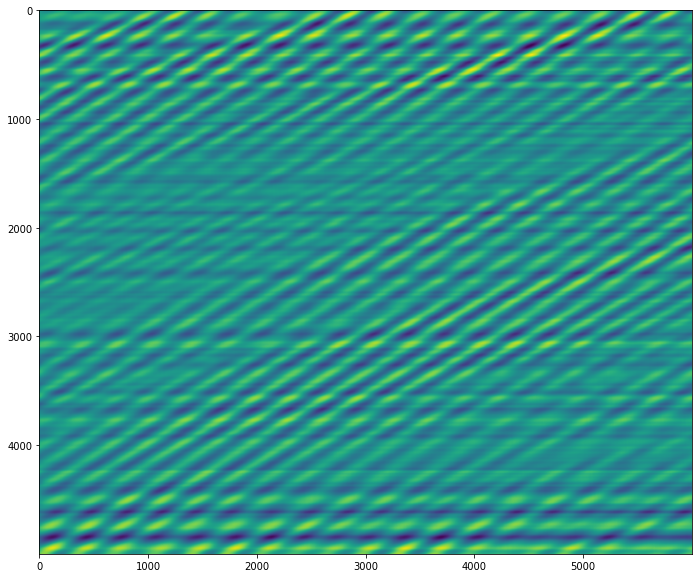

In [23]:
plt.figure(figsize=(12,10))
plt.imshow(working_dat[:,:,0])
plt.show()

In [24]:
xs = np.arange(working_dat.shape[0])
print(xs.shape)

(5000,)


### Dataset 1

In [25]:
thresh = 1.
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fba3a1454f0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=1.0))

In [26]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 1.0
(x0)' = -6.298 x0_111


In [27]:
thresh = 0.4
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fba3a1454f0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.4))

In [28]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.4
(x0)' = -6.782 x0_111 + 0.423 x0x0x0_111


In [29]:
thresh = 0.2
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fba3a1454f0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.2))

In [30]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.2
(x0)' = 0.431 x0_1 + 18.967 x0_111 + 0.604 x0x0x0_111


In [31]:
thresh = 0.1
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fba3a1454f0>,
      feature_names=['x0'], optimizer=STLSQ(alpha=0.001, max_iter=100))

In [32]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.1
(x0)' = 0.431 x0_1 + 18.948 x0_111 + -0.609 x0x0_111 + 0.597 x0x0x0_111


### Dataset 2

In [33]:
working_dat = np.zeros((5000,6000))
b=0
for q in np.arange(10,15):

    working_dat[:,b*(1200):(b+1)*1200] = np.load(file_list[q])[:,::10]
    b+=1
# working_dat = ((2*np.pi)/2**16)*((1550.12 * 1e-9)/(0.78 * 4 * np.pi * n * L))*working_dat[:,::10]
working_dat = working_dat/(np.std(working_dat))
working_dat = working_dat.reshape(working_dat.shape[0],working_dat.shape[1],1)

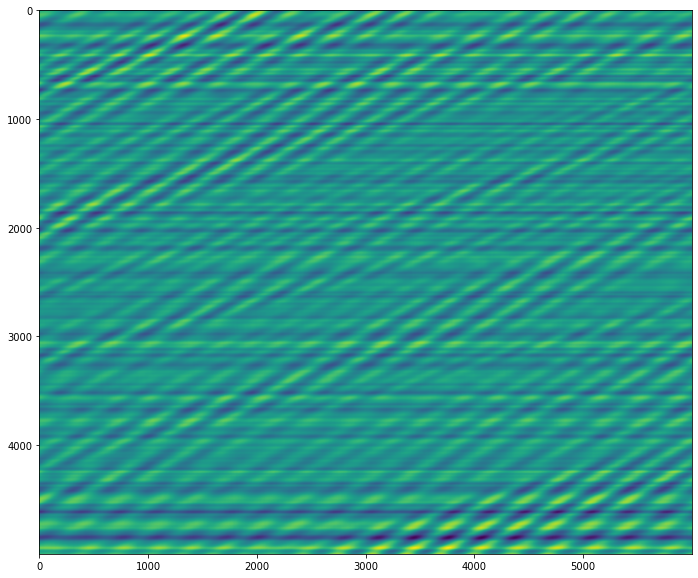

In [34]:
plt.figure(figsize=(12,10))
plt.imshow(working_dat[:,:,0])
plt.show()

In [ ]:
thresh = 1.
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

In [36]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 1.0
(x0)' = 0.000


In [37]:
thresh = 0.4
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

/home/ldoyle/packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (0.4) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (0.4) and eliminated all coefficients
  warnings.warn(


SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fba3a1454f0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.4))

In [38]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.4
(x0)' = -1.154 x0_111


In [39]:
thresh = 0.2
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fba3a1454f0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.2))

In [40]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.2
(x0)' = 0.275 x0_1 + 12.396 x0_111 + 0.150 x0x0x0_111


In [41]:
thresh = 0.1
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fba3a1454f0>,
      feature_names=['x0'], optimizer=STLSQ(alpha=0.001, max_iter=100))

In [42]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.1
(x0)' = 0.275 x0_1 + 12.396 x0_111 + 0.150 x0x0x0_111


## Drift Removal Load

In [43]:
working_dat = np.load("/home/ldoyle/notebooks/channel_drift_5_min_clips/normalized_5_min_start_11.npy")[:,::10]
working_dat = working_dat.reshape(working_dat.shape[0],working_dat.shape[1],1)
xs = np.arange(working_dat.shape[0])

In [44]:
thresh = 9e-2
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fba3a1454f0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.09))

In [45]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.09
(x0)' = 0.235 x0_1 + 0.107 x0_111


In [46]:
thresh = 5e-2
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


# library_ensemble_coefs = model.coef_list
# mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
# std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fba3a1454f0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.05))

In [47]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.05
(x0)' = 0.235 x0_1 + 0.107 x0_111


In [48]:
thresh = 1e-2
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fba3a1454f0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.01))

In [49]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.01
(x0)' = 0.265 x0_1 + 0.123 x0_111 + -0.056 x0x0x0_1 + -0.028 x0x0x0_111


### Dataset 2

In [50]:
working_dat = np.load("/home/ldoyle/notebooks/channel_drift_5_min_clips/normalized_5_min_start_21.npy")[:,::10]
working_dat = working_dat.reshape(working_dat.shape[0],working_dat.shape[1],1)
xs = np.arange(working_dat.shape[0])

In [51]:
thresh = 9e-2
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fba3a1454f0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.09))

In [52]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.09
(x0)' = 0.216 x0_1 + 0.100 x0_111


In [53]:
thresh = 5e-2
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


# library_ensemble_coefs = model.coef_list
# mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
# std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fba3a1454f0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.05))

In [54]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.05
(x0)' = 0.224 x0_1 + 0.100 x0_111 + -0.045 x0x0x0_1


In [55]:
thresh = 1e-2
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fba3a1454f0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.01))

In [56]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.01
(x0)' = 0.236 x0_1 + 0.111 x0_111 + 0.003 x0x0_1 + -0.113 x0x0x0_1 + -0.060 x0x0x0_111


## Multifilt

In [57]:
working_dat = np.load("/home/ldoyle/notebooks/channel_drift_5_min_clips/smoothed_decimated_normalized_5_min_start_11.npy")
working_dat = working_dat.reshape(working_dat.shape[0],working_dat.shape[1],1)


### Dataset 1

In [58]:
thresh = 0.5
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fba3a1454f0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.5))

In [59]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.5
(x0)' = 0.594 x0_1 + 4.058 x0_111 + 0.077 x0x0x0_111


In [60]:
thresh = 0.1
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


# library_ensemble_coefs = model.coef_list
# mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
# std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fba3a1454f0>,
      feature_names=['x0'], optimizer=STLSQ(alpha=0.001, max_iter=100))

In [61]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.1
(x0)' = 0.594 x0_1 + 4.058 x0_111 + 0.077 x0x0x0_111


In [62]:
thresh = 3e-2
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fba3a1454f0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.03))

In [63]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.03
(x0)' = 0.594 x0_1 + 4.058 x0_111 + 0.077 x0x0x0_111


In [64]:
thresh = 1e-2
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fba3a1454f0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.01))

In [65]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.01
(x0)' = 0.603 x0_1 + -0.005 x0_11 + 4.139 x0_111 + -0.022 x0x0x0_1 + 0.003 x0x0x0_11 + 0.014 x0x0_111 + -0.113 x0x0x0_111


### Dataset 2

In [66]:
working_dat = np.load("/home/ldoyle/notebooks/channel_drift_5_min_clips/smoothed_decimated_normalized_5_min_start_21.npy")
working_dat = working_dat.reshape(working_dat.shape[0],working_dat.shape[1],1)


In [67]:
thresh = 0.5
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fba3a1454f0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.5))

In [68]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.5
(x0)' = 0.572 x0_1 + 3.861 x0_111


In [69]:
thresh = 0.1
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


# library_ensemble_coefs = model.coef_list
# mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
# std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fba3a1454f0>,
      feature_names=['x0'], optimizer=STLSQ(alpha=0.001, max_iter=100))

In [70]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.1
(x0)' = 0.572 x0_1 + 3.842 x0_111 + 0.109 x0x0x0_111


In [71]:
thresh = 3e-2
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fba3a1454f0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.03))

In [72]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.03
(x0)' = 0.578 x0_1 + 3.890 x0_111 + -0.040 x0x0x0_1 + -0.221 x0x0x0_111


In [73]:
thresh = 1e-2
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fba3a1454f0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.01))

In [74]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.01
(x0)' = 0.578 x0_1 + 3.890 x0_111 + -0.040 x0x0x0_1 + -0.221 x0x0x0_111
